# Summary

Starting point for a supervised learning model for Ookla speed tiles. The data comes from a combination of 
Ookla Open Data speed tests and Statistics Canada information, including 2016 census population data and census boundaries (shapefiles). 


In [1]:
import sys
sys.path.append("..")

In [2]:
import src.config

In [3]:
from src.datasets.loading import statcan, ookla

In [4]:
import numpy as np 
import pandas as pd
import geopandas as gp

In [5]:
from sklearn import preprocessing, pipeline, compose
from sklearn import linear_model, model_selection, svm
from sklearn import metrics

In [6]:
import matplotlib.pyplot as plt 

## Load 
Load some of the available data. The census population data and StatCan boundaries are automatically loaded from 
the StatCan website. The overlays and tile geometries/speeds need to pre-computed and saved to the overlays directory and data directories. 

### Load All Unique Tile Gemoetries

In [7]:
ookla_tiles = ookla.canada_tiles()

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [8]:
ookla_tiles['quadkey'] = ookla_tiles['quadkey'].astype(int)

In [9]:
ookla_tiles

,quadkey,geometry
0,302303331012303,"POLYGON ((-73.36121 45.53329, -73.35571 45.533..."
1,212122230130321,"POLYGON ((-122.75574 49.30364, -122.75024 49.3..."
2,212120311013031,"POLYGON ((-121.14075 51.58390, -121.13525 51.5..."
3,212102012132221,"POLYGON ((-122.77771 53.85901, -122.77222 53.8..."
4,212122232013120,"POLYGON ((-122.89307 49.11703, -122.88757 49.1..."
...,...,...
640785,303301220300321,"POLYGON ((-53.23425 47.37603, -53.22876 47.376..."
640786,303301221112323,"POLYGON ((-52.79480 47.46152, -52.78931 47.461..."
640787,303301221332020,"POLYGON ((-52.82227 47.30158, -52.81677 47.301..."
640788,303301223111010,"POLYGON ((-52.76733 47.27923, -52.76184 47.279..."


### Load Census Population Information

In [10]:
da_pops = statcan.dissemination_areas_populations()

/home/jovyan/src/datasets/loading/statcan.py:104: DtypeWarning: Columns (3,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(POP_FILE)


In [11]:
pd.read_csv('98-400-X2016003_English_CSV_data.csv')

/tmp/ipykernel_2171/1065142098.py:1: DtypeWarning: Columns (3,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('98-400-X2016003_English_CSV_data.csv')


,CENSUS_YEAR,GEO_CODE (POR),GEO_LEVEL,GEO_NAME,GNR,DATA_QUALITY_FLAG,CSD_TYPE_NAME,ALT_GEO_CODE,DIM: Age (in single years) and average age (127),Member ID: Age (in single years) and average age (127),Notes: Age (in single years) and average age (127),Dim: Sex (3): Member ID: [1]: Total - Sex,Dim: Sex (3): Member ID: [2]: Male,Dim: Sex (3): Member ID: [3]: Female
0,2016,1,0,Canada,4.0,20000,,1,Total - Age,1,NaN,35151730.0,17264200.0,17887530.0
1,2016,1,0,Canada,4.0,20000,,1,0 to 14 years,2,NaN,5839570.0,2992920.0,2846645.0
2,2016,1,0,Canada,4.0,20000,,1,0 to 4 years,3,NaN,1898790.0,973030.0,925755.0
3,2016,1,0,Canada,4.0,20000,,1,Under 1 year,4,NaN,369730.0,189085.0,180650.0
4,2016,1,0,Canada,4.0,20000,,1,1,5,NaN,372615.0,190905.0,181715.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7606787,2016,62080017,4,62080017,7.6,100,,62080870017,97,123,NaN,0.0,0.0,0.0
7606788,2016,62080017,4,62080017,7.6,100,,62080870017,98,124,NaN,0.0,0.0,0.0
7606789,2016,62080017,4,62080017,7.6,100,,62080870017,99,125,NaN,0.0,0.0,0.0
7606790,2016,62080017,4,62080017,7.6,100,,62080870017,100 years and over,126,NaN,0.0,0.0,0.0


In [12]:
da_pops

,DAUID,GEO_NAME,DAPOP
508,10010734,10010734,150.0
762,10010735,10010735,350.0
889,10010736,10010736,130.0
1143,10010733,10010733,65.0
1397,10010737,10010737,365.0
...,...,...,...
7605903,62080023,62080023,590.0
7606030,62080024,62080024,465.0
7606284,62080027,62080027,760.0
7606411,62080028,62080028,565.0


### Labelling Tiles
Generate labels from geometric overlay of the Ookla tiles and Statistics Canada Dissemination Areas (DA). 
Label each tile with the information from the StatCan areas based on which DA the tile overlaps the most with.

In [13]:
o = gp.read_file(src.config.OVERLAYS_DIR / 'tile_das_overlay') #this can take a few minutes to load.
tile_da_label = o.dropna(subset=['DAUID','quadkey']).sort_values(by=['quadkey','tile_frac'],ascending=False).drop_duplicates(subset='quadkey', keep='first')
tile_da_label['quadkey'] = tile_da_label['quadkey'].astype(int)
tile_da_label['DAUID'] = tile_da_label['DAUID'].astype(int)

In [14]:
tile_da_label.head(5)

,DAUID,PRUID,PRNAME,CDUID,CDNAME,CDTYPE,CCSUID,CCSNAME,CSDUID,CSDNAME,...,CMATYPE,CTUID,CTNAME,ADAUID,das_area,quadkey,tile_area,tile_frac,das_frac,geometry
6296,10010732,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001214,"Division No. 1, Subd. C",1001101,"Division No. 1, Subd. V",...,None,None,None,10010032,9.644073e+08,303303003200203,179657.055800,0.769603,0.000143,"POLYGON ((9015626.860 2053485.200, 9015560.523..."
6297,10010732,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001214,"Division No. 1, Subd. C",1001101,"Division No. 1, Subd. V",...,None,None,None,10010032,9.644073e+08,303303002300031,179564.518589,0.680347,0.000127,"POLYGON ((9004162.306 2047133.489, 9004129.314..."
6295,10010732,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001214,"Division No. 1, Subd. C",1001101,"Division No. 1, Subd. V",...,None,None,None,10010032,9.644073e+08,303303002300013,179533.683403,0.918086,0.000171,"POLYGON ((9004044.083 2047460.354, 9004001.591..."
6294,10010734,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001214,"Division No. 1, Subd. C",1001105,Portugal Cove South,...,None,None,None,10010032,1.194131e+06,303303002122003,179287.191780,0.912957,0.137072,"POLYGON ((9001504.369 2049856.597, 9001421.325..."
6300,10010734,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001214,"Division No. 1, Subd. C",1001105,Portugal Cove South,...,None,None,None,10010032,1.194131e+06,303303002122002,179287.191779,0.514279,0.077214,"POLYGON ((9001099.220 2049524.689, 9001057.409..."


### Speed Test Data
Load in the previous 4 quarters of data. Since we're currently in Q3 of 2022, the most recent quarter is Q2 
so we can slice the files listed to grab those. Subsequently, we'll calculate weighted averages for individual tiles and use those as representative speeds for our model.

In [15]:
last_4_quarters = ookla.speed_data(ookla.available_files().loc[('fixed',2021,3):('fixed',2022,2)].path)

In [16]:
last_4_quarters

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,conn_type,year,quarter
0,212003102331113,8630,659,36,5,3,fixed,2021,3
1,213121302312313,64252,22859,72,3,2,fixed,2021,3
2,302231303123012,179499,108278,8,25,16,fixed,2021,3
3,302303331021312,190314,75560,8,113,25,fixed,2021,3
4,302231231303201,228151,18968,16,36,16,fixed,2021,3
...,...,...,...,...,...,...,...,...,...
190701,302312230212302,52531,19656,2,4,1,fixed,2022,2
190702,302311222021021,7517,6905,7,1,1,fixed,2022,2
190703,213120031002112,12572,2001,77,3,1,fixed,2022,2
190704,303200002223332,110033,72022,4,1,1,fixed,2022,2


In [17]:
down = last_4_quarters.groupby('quadkey').apply(lambda s:np.average(s.avg_d_kbps, weights=s.tests)).rename('avg_d_kbps')
up = last_4_quarters.groupby('quadkey').apply(lambda s:np.average(s.avg_u_kbps, weights=s.tests)).rename('avg_u_kbps')
tests = last_4_quarters.groupby('quadkey')['tests'].sum()
devices = last_4_quarters.groupby('quadkey')['devices'].sum()
last4_agg = pd.concat([down, up, tests, devices],axis=1)

In [18]:
last4_agg

,avg_d_kbps,avg_u_kbps,tests,devices
quadkey,,,,
23331133131233,11442.235294,646.705882,17,8
23331133131301,899.000000,90.333333,3,2
23331133133011,13074.333333,534.666667,3,3
23331133133113,11537.000000,546.000000,6,2
23332010021132,3669.000000,1101.000000,1,1
...,...,...,...,...
303303002030011,43155.000000,1901.000000,1,1
303303002032102,1634.000000,690.000000,1,1
303303002122000,37799.000000,12489.000000,1,1


### Merge All The Data
It's a bit messy, but we're merging several tables and removing a few of the redundant or non-useful 
columns as we go through. At the end the `features_table` variable will have all of the 
tiles within census areas labelled by what type of Census Subdivision, Dissemination Area, Population Centre, etc. they are in, as well as population information for the DA (smallest area with populations available) and the speed test averages over the last 4 quarters.

In [19]:
## merge dissemination area (DA) populations with ookla tiles (already combined with other statcan data)
features_table = tile_da_label.merge(da_pops, on='DAUID', how='left')
features_table['DAPOP'] = features_table['DAPOP'].fillna(0).astype(int)
del features_table['GEO_NAME']
features_table = pd.DataFrame(features_table)
del features_table['geometry']
features_table['POP_DENSITY'] = features_table['DAPOP']/features_table['das_area']*1000**2 #people per square kilometer

# take all ookla tiles, merge the speeds data and tile labels and populations
features_table = ookla_tiles.merge(last4_agg, on='quadkey').merge(features_table, on='quadkey')
# features_table_ = pd.concat([ookla_tiles, last4_agg], keys='quadkey')
# features_table = pd.concat([features_table_, features_table], keys='quadkey')

# compute spatial joins to identify if area is a population centre
pop_info = statcan.boundary('population_centres').to_crs('epsg:4326')
pop_info = pop_info[['PCUID', 'PCNAME', 'PCTYPE', 'PCPUID', 'PCCLASS', 'geometry']] ##removes some redundant cols from DAs
features_table = features_table.sjoin(pop_info, how='left')
del features_table['index_right']
features_table = features_table.sort_values(by=['PCUID','quadkey']).drop_duplicates(subset=['quadkey']) #keep tiles where overlap was true

In [28]:
features_table

,quadkey,geometry,avg_d_kbps,avg_u_kbps,tests,devices,DAUID,PRUID,PRNAME,CDUID,...,tile_area,tile_frac,das_frac,DAPOP,POP_DENSITY,PCUID,PCNAME,PCTYPE,PCPUID,PCCLASS
32915,302231302213222,"POLYGON ((-80.02441 43.64800, -80.01892 43.648...",201908.916667,23286.833333,12,8,35240570,35,Ontario,3524,...,205331.876525,0.917314,0.041955,1420,316.301553,0001,Acton,2,350001,2
67352,302231302230013,"POLYGON ((-80.05188 43.64005, -80.04639 43.640...",393118.031250,169457.281250,32,7,35240571,35,Ontario,3524,...,205402.379648,0.894827,0.034094,1030,191.058601,0001,Acton,2,350001,2
185960,302231302230022,"POLYGON ((-80.06836 43.63210, -80.06287 43.632...",19284.750000,4310.750000,4,2,35240629,35,Ontario,3524,...,205472.906899,0.611219,0.012189,505,49.011263,0001,Acton,2,350001,2
38693,302231302230023,"POLYGON ((-80.06287 43.63210, -80.05737 43.632...",10499.585938,1387.898438,128,13,35240573,35,Ontario,3524,...,205472.906900,0.871430,0.101407,795,450.245236,0001,Acton,2,350001,2
52422,302231302230030,"POLYGON ((-80.05737 43.63608, -80.05188 43.636...",535.000000,889.000000,1,1,35240571,35,Ontario,3524,...,205437.640257,0.939933,0.035818,1030,191.058601,0001,Acton,2,350001,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283490,303303002030011,"POLYGON ((-53.33313 46.73986, -53.32764 46.739...",43155.000000,1901.000000,1,1,10010735,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,...,179010.291685,0.579748,0.005838,350,19.688054,NaN,NaN,NaN,NaN,NaN
258526,303303002032102,"POLYGON ((-53.32764 46.70597, -53.32214 46.705...",1634.000000,690.000000,1,1,10010735,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,...,179287.191779,0.533632,0.005382,350,19.688054,NaN,NaN,NaN,NaN,NaN
214590,303303002122000,"POLYGON ((-53.26172 46.70974, -53.25623 46.709...",37799.000000,12489.000000,1,1,10010734,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,...,179256.404037,0.574792,0.086285,150,125.614323,NaN,NaN,NaN,NaN,NaN
285250,303303002122001,"POLYGON ((-53.25623 46.70974, -53.25073 46.709...",40291.272727,9116.000000,11,3,10010734,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,...,179256.404037,1.000000,0.150114,150,125.614323,NaN,NaN,NaN,NaN,NaN


### Categorize All the Columns
All the columns from our joins above can be roughly split into categories based on the type of 
data and how you might use them in a simple supervised learning problem. These are broken down as follows:

In [20]:
pkey = 'quadkey'
geometry = 'geometry'
id_and_names = ['DAUID', 'CDUID', 'CDNAME', 'CCSUID', 'CSDNAME', 'CMAUID', 'CMAPUID', 'CMANAME', 
'CCSNAME', 'CSDUID', 'ERUID', 'ERNAME', 'CTUID', 'CTNAME', 'ADAUID', 
'PCUID', 'PCNAME', 'PCPUID', 'SACCODE',] ##SACCODE is half a category half ID values

categorical_labels = [
    #'PRUID', #PRUID is redundant with PRNAME
    'PRNAME', 'CDTYPE', 
    'CSDTYPE',  
    'SACTYPE', 
    'CMATYPE', 'PCTYPE', 'PCCLASS',
]
numerical_vars = [
    'tests', 'devices',
    'das_area', 'tile_area', 'tile_frac',  'das_frac', 
    'DAPOP','POP_DENSITY'
]
target_vars = ['avg_d_kbps', 'avg_u_kbps']

In [21]:
col_subset = [pkey] + categorical_labels + numerical_vars + target_vars
features_table.loc[:,col_subset].set_index('quadkey')

,PRNAME,CDTYPE,CSDTYPE,SACTYPE,CMATYPE,PCTYPE,PCCLASS,tests,devices,das_area,tile_area,tile_frac,das_frac,DAPOP,POP_DENSITY,avg_d_kbps,avg_u_kbps
quadkey,,,,,,,,,,,,,,,,,
302231302213222,Ontario,RM,T,1,B,2,2,12,8,4.489387e+06,205331.876525,0.917314,0.041955,1420,316.301553,201908.916667,23286.833333
302231302230013,Ontario,RM,T,1,B,2,2,32,7,5.391016e+06,205402.379648,0.894827,0.034094,1030,191.058601,393118.031250,169457.281250
302231302230022,Ontario,RM,T,1,B,2,2,4,2,1.030375e+07,205472.906899,0.611219,0.012189,505,49.011263,19284.750000,4310.750000
302231302230023,Ontario,RM,T,1,B,2,2,128,13,1.765704e+06,205472.906900,0.871430,0.101407,795,450.245236,10499.585938,1387.898438
302231302230030,Ontario,RM,T,1,B,2,2,1,1,5.391016e+06,205437.640257,0.939933,0.035818,1030,191.058601,535.000000,889.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303303002030011,Newfoundland and Labrador / Terre-Neuve-et-Lab...,CDR,T,5,None,NaN,NaN,1,1,1.777728e+07,179010.291685,0.579748,0.005838,350,19.688054,43155.000000,1901.000000
303303002032102,Newfoundland and Labrador / Terre-Neuve-et-Lab...,CDR,T,5,None,NaN,NaN,1,1,1.777728e+07,179287.191779,0.533632,0.005382,350,19.688054,1634.000000,690.000000
303303002122000,Newfoundland and Labrador / Terre-Neuve-et-Lab...,CDR,T,7,None,NaN,NaN,1,1,1.194131e+06,179256.404037,0.574792,0.086285,150,125.614323,37799.000000,12489.000000


## Train A Simple ML Model

In [22]:
#Standard train/test where down and/or up speeds are the target/predicted continuous variable.
X_train, X_test, \
down_train, down_test, \
up_train, up_test = model_selection.train_test_split(
    features_table, features_table['avg_d_kbps'], features_table['avg_u_kbps']
)

In [23]:
# Normalize the numerical Data and OneHot encode the categorical vars.
colTransformer = compose.ColumnTransformer(
    [(f"{cat}",preprocessing.OneHotEncoder(),[cat]) for cat in categorical_labels] \
    + [(f"{num}", preprocessing.StandardScaler(), [num]) for num in numerical_vars] 
    #+ [(f"{y}_stdscaler", preprocessing.StandardScaler(), [y]) for y in target_vars]
)

#Setup a regressor for predicting down/up speeds.
ridge = linear_model.RidgeCV()
regressor = compose.TransformedTargetRegressor(
    regressor=ridge,
    transformer=preprocessing.PowerTransformer(method='box-cox')
)

# Combine above in a reuseable pipeline object
pipe = pipeline.Pipeline([
    ('preprocess',colTransformer),
    ('regressor', regressor)
])

In [24]:
#train the model
pipe.fit(X_train, down_train);

### Look at Some Analytics
The performance isn't very good, specifically if we consider the context of 
determining if individuals can access internet at the Federal 50/10 Mbps commitment level.

In [25]:
# how did it do on the training set
# speeds are in kbps
{"Mean Absolute Error":metrics.mean_absolute_error(pipe.predict(X_train), down_train),
"Median Absolute Error":metrics.median_absolute_error(pipe.predict(X_train), down_train),
"Mean Absolute Percentage Error":metrics.mean_absolute_percentage_error(pipe.predict(X_train), down_train)}

{'Mean Absolute Error': 62299.739974152515,
 'Median Absolute Error': 33927.112980710124,
 'Mean Absolute Percentage Error': 1.0954453979327448}

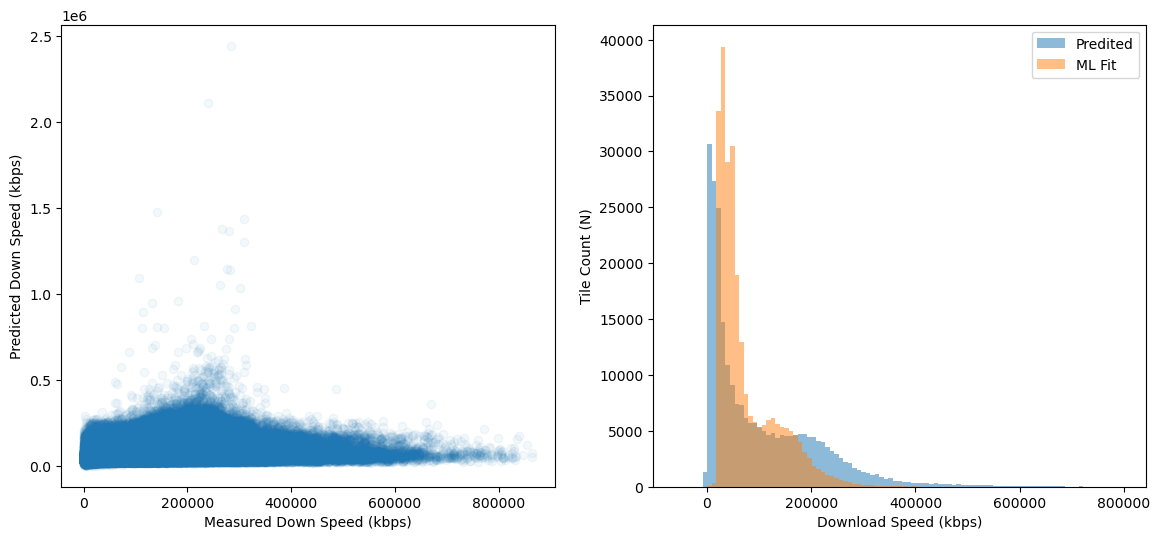

In [26]:
fig, axs = plt.subplots(1,2, figsize=(14,6))
axs[0].scatter(down_train, pipe.predict(X_train), alpha=0.05);
axs[0].set(xlabel="Measured Down Speed (kbps)", ylabel="Predicted Down Speed (kbps)");

bins = np.linspace(-60000,800000,100)
axs[1].hist(down_train,alpha=0.5, bins=bins,label='Predited')
axs[1].hist(pipe.predict(X_train),alpha=0.5, bins=bins,label='ML Fit');
axs[1].legend()
axs[1].set(xlabel='Download Speed (kbps)', ylabel='Tile Count (N)');

<AxesSubplot: >

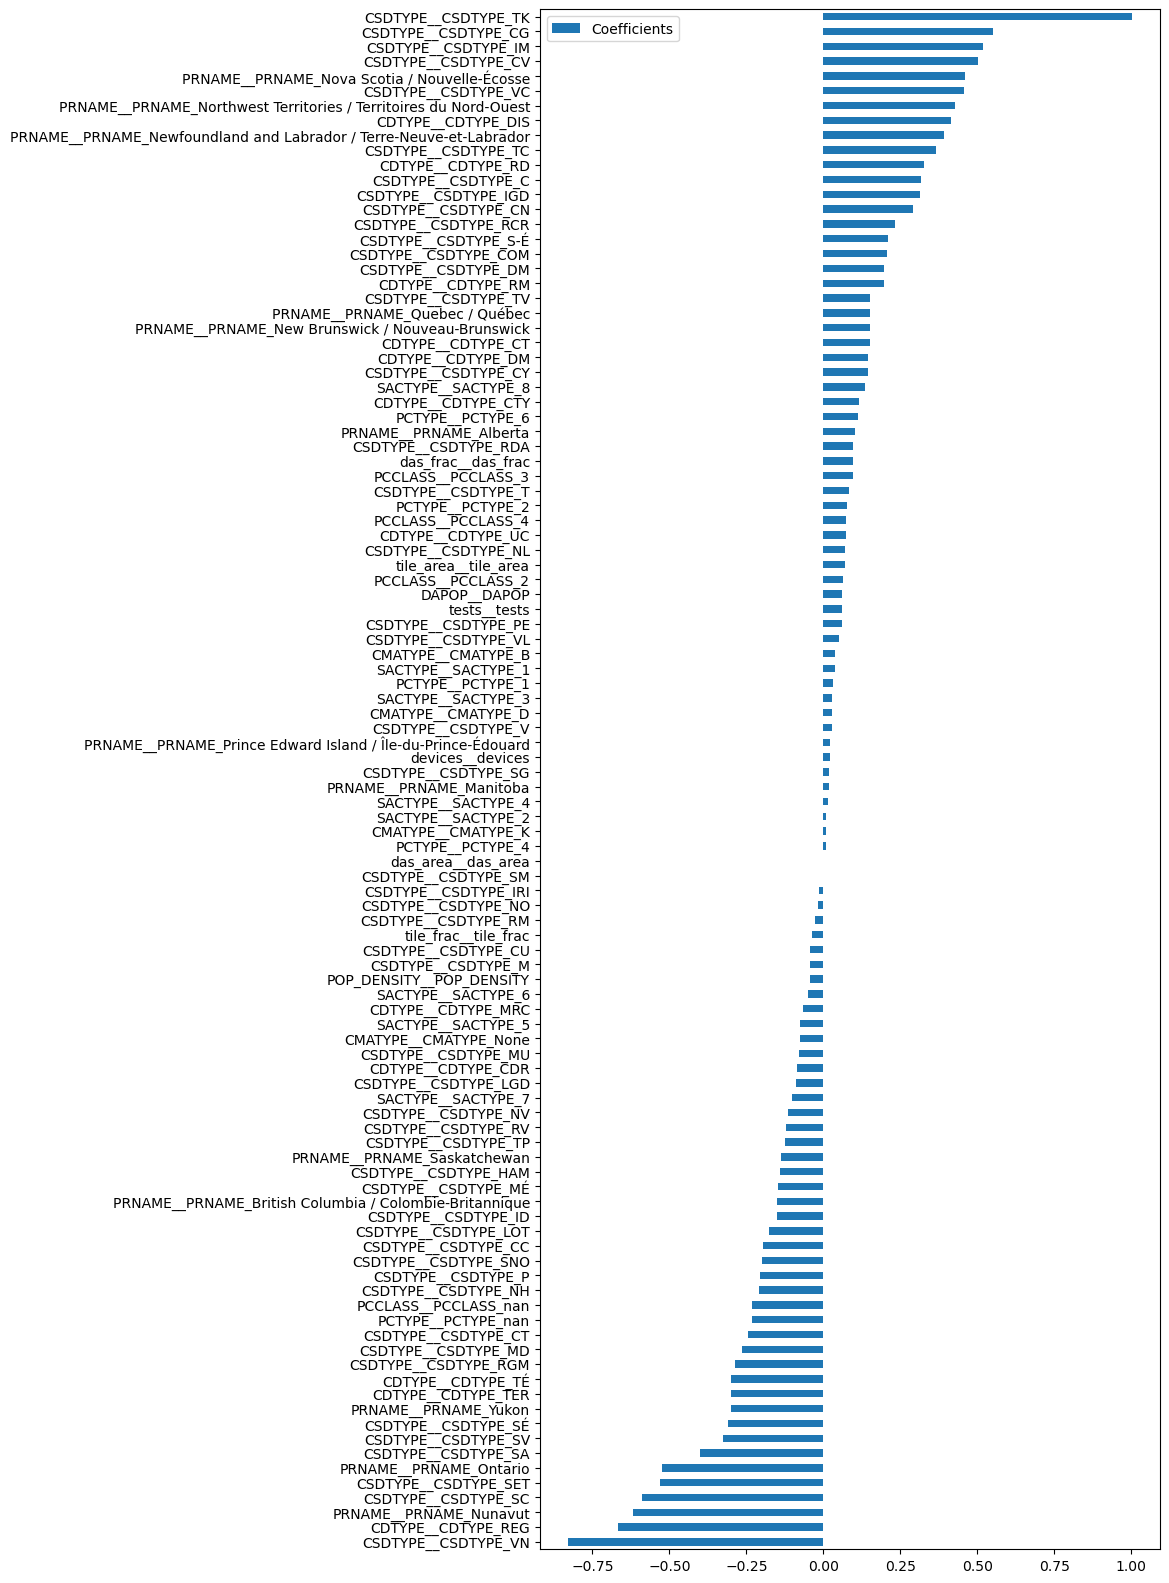

In [27]:
# What are the important coefficients.
coefs = pd.DataFrame(pipe[-1].regressor_.coef_,columns=['Coefficients'],index=pipe[:-1].get_feature_names_out())
coefs.sort_values(by='Coefficients').plot.barh(figsize=(8,20))

In [29]:
X_train

,quadkey,geometry,avg_d_kbps,avg_u_kbps,tests,devices,DAUID,PRUID,PRNAME,CDUID,...,tile_area,tile_frac,das_frac,DAPOP,POP_DENSITY,PCUID,PCNAME,PCTYPE,PCPUID,PCCLASS
173798,303221101333221,"POLYGON ((-62.61658 44.84808, -62.61108 44.848...",7380.000000,539.000000,1,1,12090924,12,Nova Scotia / Nouvelle-Écosse,1209,...,194857.559912,1.000000,0.000623,805,2.572737,NaN,NaN,NaN,NaN,NaN
265287,302213022021232,"POLYGON ((-81.50757 46.22925, -81.50208 46.229...",118043.021739,11911.963768,138,13,35520115,35,Ontario,3552,...,183208.898259,1.000000,0.000376,295,0.605104,NaN,NaN,NaN,NaN,NaN
123010,302303122111231,"POLYGON ((-74.20715 46.29382, -74.20166 46.293...",52393.400000,10364.600000,5,2,24620187,24,Quebec / Québec,2462,...,182674.832507,1.000000,0.003688,585,11.809152,NaN,NaN,NaN,NaN,NaN
331228,302231033232123,"POLYGON ((-80.39246 44.10731, -80.38696 44.107...",69710.000000,6827.000000,6,2,35220145,35,Ontario,3522,...,201283.683753,0.701263,0.001252,815,7.230053,NaN,NaN,NaN,NaN,NaN
25663,302213332300000,"POLYGON ((-79.27734 45.21300, -79.27185 45.213...",298004.166667,296738.500000,12,7,35440189,35,Ontario,3544,...,191738.026881,0.649692,0.007541,505,30.569034,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250697,213120002103331,"POLYGON ((-100.99182 52.22107, -100.98633 52.2...",7566.000000,2177.000000,7,2,46200032,46,Manitoba,4620,...,137438.930066,1.000000,0.000198,520,0.750116,NaN,NaN,NaN,NaN,NaN
212036,303300133003211,"POLYGON ((-53.72864 48.18074, -53.72314 48.180...",14606.360656,2179.327869,61,4,10070519,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1007,...,167469.359299,0.768537,0.000259,680,1.366009,NaN,NaN,NaN,NaN,NaN
301597,213121222010031,"POLYGON ((-98.33313 50.95151, -98.32764 50.951...",36193.000000,1964.000000,1,1,46180087,46,Manitoba,4618,...,146514.055477,0.939161,0.000206,380,0.569461,NaN,NaN,NaN,NaN,NaN
24004,302302320103303,"POLYGON ((-77.09656 45.53329, -77.09106 45.533...",39023.333333,9605.833333,6,5,35470239,35,Ontario,3547,...,189024.937155,0.965139,0.002069,800,9.074552,0256,Eganville,4,350256,2
